In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import torch


In [2]:
# load MNIST data
mnist_data=torchvision.datasets.MNIST('.',transform=torchvision.transforms.ToTensor())

In [3]:
# the next two cells are loading the necassary things to use the BNETs

In [4]:
def lambda_initaliser(n): #bigger Lambda means smaller effective updates, more regularisation, more precise prior
#     return (np.ones((n,n))+np.eye(n))*1e1
#     return (-1*np.ones((n,n))+np.eye(n)*(n))*1
#     return (np.ones((n,n))+np.diag(np.random.rand(n))+np.random.rand(n,n)*0.1)*1
    return (np.eye(n))/n**1#/np.sqrt(n)
#     return np.ones((n,n))*1e-4

def initialiser_function(rows,columns):
#     return np.random.randn(rows,columns)
#     inits= np.zeros((rows,columns))+np.random.randn(rows,columns)*0.1
#     inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)
    inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.randn(rows,columns))*np.sqrt(2)/np.sqrt(rows)

#     inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)

#     inits=(np.random.randn(rows,columns)*2)*np.sqrt(6)/np.sqrt(rows+columns)*0
#     inits=(np.random.randn(rows,columns))*0.1#*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.rand(rows,columns)*2-1)*np.sqrt(6)/np.sqrt(rows+columns)

#     inits[0,:]=np.ones((1,columns))
    return inits

def find_Y(Y,w1,X0): 
    # This function finds the new Y value for the layer, by going 'backwards' through the matrix
    # initally we had X0 @ w0 = Y, and then updated w0 -> w1, so now we solve X1 @ w1 = Y for X1
    # this is often under determined, and so we find the X1 which is closest (L2 norm) to X0

    delta=w1 @ np.linalg.inv(w1.T @ w1) @ (Y - X0 @ w1).T
    X1 = X0+delta.T

    # remember to kill bias if needed
    return X1

In [5]:
class BNet7:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,return_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        if return_error:
            error1=[]
            error2=[]
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample
                if sample_used[ii]<passes and sample_attempted[ii]< failed_attempts: #if this data hasn't already been used too many times
                    x=xx[ii,:]
                    x=x.reshape((1,x.shape[0]))                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))

                    Y_out,all_activated=self.forward(x) #do a forward pass
                    # Y_out is just used for printing the error
                    # all_activated = 1 if all layers have at least one activated neuron
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2) #calculate MSE
                    if all_activated:
                        sample_used[ii]+=1 #count the times this sample has been used

#                         Y_out,all_activated=self.forward(x) #do a forward pass each time to calculate new values of self.a etc

                        for ll in range(len(self.weights)-1,-1,-1):
                            #updating the weight matrices, starting from the final one
                            
                            if ll==0:
                                xl=np.hstack([np.ones((x.shape[0],1)),x])
                            else:
                                xl=self.a[ll-1] #set xl to the 'input' of the weight matrix

                            if ll==len(self.weights)-1: 
                                # if we are updating the final weight matrix (which we do first)
                                # then set Yl to the actual value of Y, and w to the weight matrix
                                Yl=Y
                                w=self.weights[ll] #this is a tempory variable for the weights which get updated
                                # because we are using the identity as the final acivation function 
                                # this is just the weight matrix, we don't need to modify it
                            else:

                                # various options for doing the 'inversion' step
                                # can simply pseudoinvert the weights, and the normalise to the bias
#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise

                                # can use our fancy invert method to find the closest Yl to a_l
                                # here we just entirely leave out the bias
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])

                                # or can use our fancy method, but include the bias and normalise to it
                                Yl= find_Y(Yl, w, self.a[ll])
                                Yl=Yl[:,1:]/Yl[0,0]

                                # I think there may be a better way to do this, which *forces* the first element of
                                # Yl to be one (which we would then remove)
                                # and makes the rest of Yl as close to a_l as possible


                                Yl=Yl[:,self.activated[ll][0,1:]] # select only the elements of Yl which correspond to activations

                                w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations


                            L=self.Lambda[ll] # make a tempory variable for Lambda 

                            # now we have the actual updating!
                            # update the weight matrix
#                             print('Yl')
#                             print(Yl.shape)
#                             print('xl')
#                             print(xl.shape)
#                             print('L')
#                             print(L.shape)
#                             print('w')
#                             print(w.shape)
                            w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)

#                                 w=np.nan_to_num(w)
                            # update the Lambda
                            L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])

                            if ll==len(self.weights)-1: #if updating the final layer, just set it equal to w
                                self.weights[ll]=w
                            else: #otherwise just update the elements which were updated
                                self.weights[ll][:,self.activated[ll][0,1:]]=w
                            self.Lambda[ll]=L # set Lambda to the new Lambda
                        Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes
                        error_out2=np.sum((Y-Y_out)**2) # calculate the new error
                        if return_error:
                            error1.append(error_out1)
                            error2.append(error_out2)
                    else: # if it failed because there were no activations
#                         print('not today')
                        sample_attempted[ii]+=1 # count fails for this sample
#                     Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes

#                     error_out2=np.sum((Y-Y_out)**2) # calculate the new error

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2)
                              +' \nTotal fails (no activations): ' +str(int(sum(sample_attempted))), end="\n\r", flush=True)

            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                # if for each sample, it has either been used the correct number of times
                # or been attempted and failed the max number of times 
                # then end the training process
                still_going=False
        if return_error:
            return error1, error2

In [6]:
def one_hot(x, class_count):
    # names a one-hot vector, of length class_count, where the x entry is a 1
    vec1=np.zeros((1,class_count))
    vec1[0,x]=1
    return vec1

In [9]:
# this loads the saved nets from training MNIST on various archetectures, and tests them

correct_fraction_all=[] # the fraction correct for each net
hidden_layers_all=[] # the hidden layer sizes
totals_all=[] # the actual count of each class
totals_correct_all=[] # the number of each class correct
n_test=10000

# make the test data
x_test=np.zeros((n_test,784))
y_test=np.zeros((n_test,10))
for ii in range(n_test):
    X_i=np.array(mnist_data[50000+ii][0]).reshape(1,784)#mnist_data[ii][0].flatten()
    Y_i=one_hot(mnist_data[50000+ii][1],10)    
    x_test[ii,:]=X_i
    y_test[ii,:]=Y_i

for file_i in range(9): # for each of the saved files
    filename='net_save'+str(file_i)+'.pkl'
    print(filename)
    with open(filename,'rb') as input:
        saved_vars=pickle.load(input) #load the file
    hidden_layers=saved_vars[0]
    save_nets=saved_vars[1] #this is a list with a bunch of saved nets
    correct_fraction=[]
    totals=[]
    totals_correct=[]
    for net1 in save_nets: # for each of the saved nets with this architechture
        Y_out=np.zeros(y_test.shape)
        for jj in range(0,n_test,1000):
            Y_out[jj:jj+1000,:]=net1.forward(x_test[jj:jj+1000,:])[0] # do a forward pass with the data

        Y_out_nums=np.argmax(Y_out,1) # convert from one-hot vectors
        Y_i_nums = np.argmax(y_test,1) 
        correct_fraction.append(np.sum(Y_out_nums==Y_i_nums)/n_test) 
        totals.append(np.sum(y_test,0))
        totals_correct.append((Y_out_nums==Y_i_nums)@y_test)

    correct_fraction_all.append(correct_fraction)
    hidden_layers_all.append(hidden_layers)
    totals_all.append(totals)
    totals_correct_all.append(totals_correct)

net_save0.pkl
net_save1.pkl
net_save2.pkl
net_save3.pkl
net_save4.pkl
net_save5.pkl
net_save6.pkl
net_save7.pkl
net_save8.pkl


In [7]:
for ii in range(0,10000,1000):
    print(ii)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [82]:
n_test=10000

x_test=np.zeros((n_test,784))
y_test=np.zeros((n_test,10))
for ii in range(n_test):
    X_i=np.array(mnist_data[50000+ii][0]).reshape(1,784)#mnist_data[ii][0].flatten()
    Y_i=one_hot(mnist_data[50000+ii][1],10)    
    x_test[ii,:]=X_i
    y_test[ii,:]=Y_i
    

In [103]:
Y_out=net1.forward(x_test)[0]
Y_out_nums=np.argmax(Y_out,1)
Y_i_nums = np.argmax(Y_i,1)
correct=np.sum(Y_out_nums==Y_i_nums)
totals=np.sum(y_test,0)
totals_correct=(Y_out_nums==Y_i_nums)@y_test


In [106]:
totals_correct

array([ 10.,   8.,  23.,  23.,   7.,  22.,   4.,   4., 833.,   9.])

In [5]:
with open('net_save3.pkl','rb') as input:
    vars0=pickle.load(input)

AttributeError: Can't get attribute 'BNet7' on <module '__main__'>

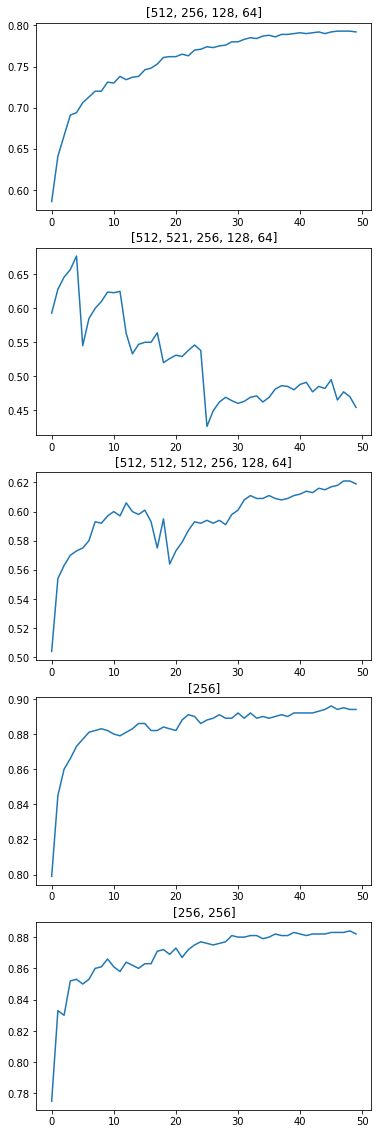

In [9]:
fig=plt.figure(figsize=(6,20))
for ii in range(5):
    fig.add_subplot(5,1,ii+1)
    plt.plot(correct_fraction_all[ii])
    plt.title(str(hidden_layers_all[ii]))

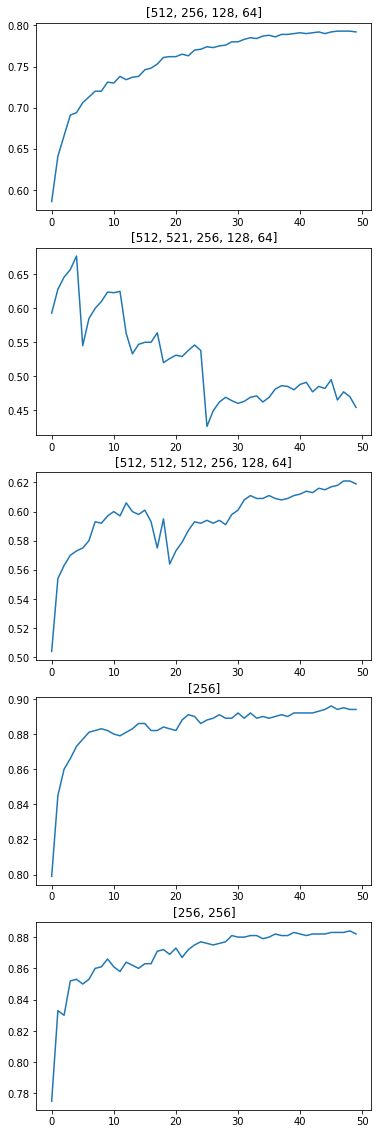

In [13]:
fig=plt.figure(figsize=(6,20))
for ii in range(5):
    fig.add_subplot(5,1,ii+1)
    plt.plot(correct_fraction_all[ii])
    plt.title(str(hidden_layers_all[ii]))

In [10]:
# this loads the saved nets from training MNIST on various archetectures
# and tests various properties of them
# testing the (psuedo) determinant of each Lambda.
# Because Lambda represents the precision for each of the weight matrices
# the determinant should be related to the 'overall' precision of the matrix
# the inverse of the determinant will give us some idea of the variance
# at a minimum we want det(Lambda) to increase over time, as we become more 'sure' about the values of the weights

detLambda_all=[]
for file_i in range(9): # for each of the saved files
    filename='net_save'+str(file_i)+'.pkl'
    print(filename)
    with open(filename,'rb') as input:
        saved_vars=pickle.load(input) #load the file
    hidden_layers=saved_vars[0]
    save_nets=saved_vars[1] #this is a list with a bunch of saved nets
    correct_fraction=[]
    net_i=0
    detLambda=np.zeros((len(save_nets),len(hidden_layers)))
    
    for net1 in save_nets: # for each of the saved nets with this architechture
        
        for ll in range(len(hidden_layers)): #this loop calculates the log of the pseudo determinant for each Lambda
            eig_values = np.linalg.eigvalsh(net1.Lambda[ll]) #calc eigen values (faster because Lambda is symetric)
            # the pseudo determinant is the product of the non-zero eigenvalues
            # but this would be too large to represent,
            # so instead we can add up the logs
            pseudo_determinent = np.sum(np.log10((eig_values[eig_values > 1e-12]))) 
            detLambda[net_i,ll]=pseudo_determinent

        net_i+=1
    detLambda_all.append(detLambda)

net_save0.pkl
net_save1.pkl
net_save2.pkl
net_save3.pkl
net_save4.pkl
net_save5.pkl
net_save6.pkl
net_save7.pkl
net_save8.pkl


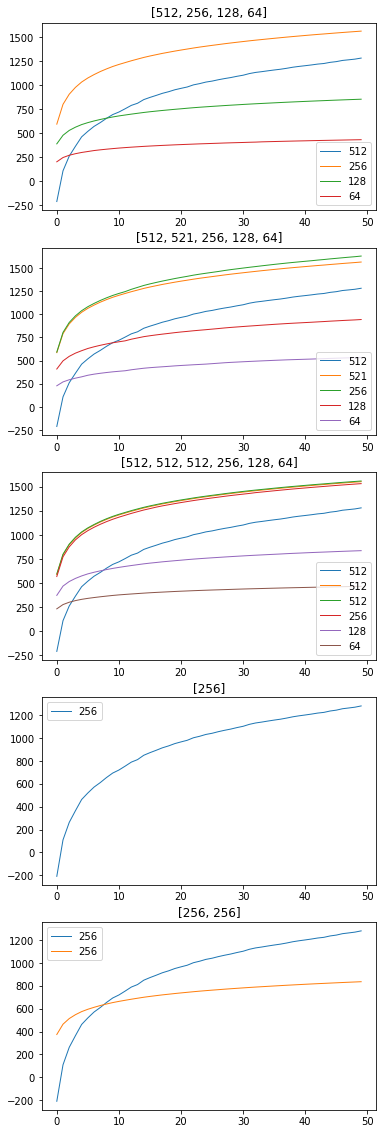

In [24]:
fig=plt.figure(figsize=(6,20))
for ii in range(5):
    fig.add_subplot(5,1,ii+1)
    plt.plot((detLambda_all[ii]),linewidth=1)
    plt.title(str(hidden_layers_all[ii]))
    plt.legend(hidden_layers_all[ii])
#     plt.ylim((0,1))

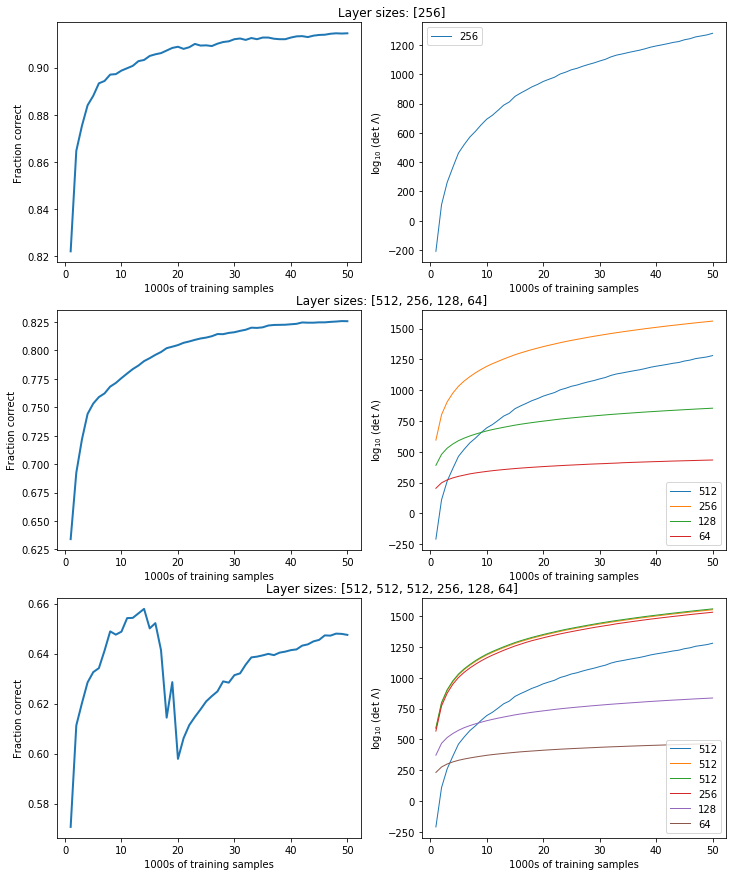

In [96]:
fig=plt.figure(figsize=(12,15))
pltnum=1
for ii in [3,0,2]:
# for ii in range(9):

    fig.add_subplot(3,2,pltnum)
    plt.plot(range(1,51),(correct_fraction_all[ii]),linewidth=2)
    t1=plt.title('Layer sizes: '+str(hidden_layers_all[ii]))
    t1.set_x(1.1)
    plt.ylabel('Fraction correct')
    plt.xlabel('1000s of training samples')
    
    fig.add_subplot(3,2,pltnum+1)
    plt.plot(range(1,51),(detLambda_all[ii]),linewidth=1)
    plt.legend(hidden_layers_all[ii])
    plt.ylabel('log$_{10}$ (det $\Lambda$)')
    plt.xlabel('1000s of training samples')

    
    pltnum+=2
#     plt.ylim((0,1))

In [73]:
t2

Text(0.5, 1, 'Layer sizes: [512, 512, 512, 256, 128, 64]')

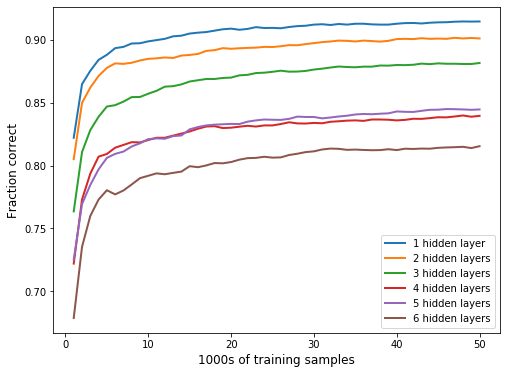

In [95]:

plt.figure(figsize=(8,6))
for ii in range(3,9):
    
    plt.plot(range(1,51),(correct_fraction_all[ii]),linewidth=2)
plt.ylabel('Fraction correct',fontsize=12)
plt.xlabel('1000s of training samples',fontsize=12)
plt.legend([str(ii)+ ' hidden layer' + 's'*(ii>1) for ii in range(1,7)])
    


In [89]:
'8'*[]

'88888888'

In [21]:
np.max(correct_fraction_all[3])

0.9145